In [1]:
#meta 1/5/2024 NLP for UDS. Part 2. Model - Baseline BOW
# Text Analytics. Trends and topic modeling for UDS
#      Data: How did you...
#      Task: Create initial BOW baseline w/ CountVectorizer

#      input: data/xx_howdidu_tidy.csv
      

#based on 1_topic_modeling.ipynb or Employee Survey 2020 (pickle with sample dataset, 2018/2019 survey results, in English only)
#meta 10/14/2020 myTopicModeling for Employee Survey 2020
#prev in 1_topic_modeling.ipynb
#10/14/2020 TOPIC MODELING - WITH TF-IDF
#      Summary of improving the extraction of words in bow
#      2 Candidate examples: 10 topics with ngram(1,3) and 2 topics with ngram(2,3)
#10/15/2020 TOPIC MODELING - LDA VIS
#      Interactive topic model visualization
#      Results with `q_better` only
#      Src https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0


#history
#1/3/2024 NLP: WORDCLOUD & TOPIC MODELING

#1/5/2024 NLP: 1ST DRAFT K-MEANS CLUSTERING

#1/8/2024 ORG MODELS
#      Algo: Latent Dirichlet Allocation
#1/31/2024 ORG MODELS
#      3 types: 1) BOW, with vis WordCloud, 2) Topic modeling & document clustering, with vis LDA, 3) K-Means Clustering, with vis 2D and 3D
#      Baseline and Candidate 1
#      #added $private tag
#1/31/2024 MISC
#      $private tag for vect_base.vocabulary_

#2/10/2004 META: MOVE TO MAC FOR SYNCING
#      local: get csv from ~2023-12-31


#Pipeline: nlp_0_data -> nlp_1_dataprep -> nlp_2_model (here)
#$config, $private


In [2]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from joblib import load, dump
#import csv

import nlp_utils

In [3]:
#modeling
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer #transformer to tokenize dataset, aka bag-of-words activity
from sklearn.feature_extraction.text import TfidfVectorizer #rescale features by how informative they are

from sklearn.decomposition import LatentDirichletAllocation

# Import the wordcloud library
from wordcloud import WordCloud

#plotly
import plotly.express as px

import IPython #for $private

In [4]:
print(sys.version)
np.__version__, pd.__version__

3.10.10 (main, Jan 17 2024, 01:36:04) [Clang 12.0.5 (clang-1205.0.22.11)]


('1.26.3', '2.1.4')

Global vars and functions

In [5]:
#data
DATA_DIR = 'myData'
DATA_FILE_IN = DATA_DIR + '/howdidu_tidy.csv' #$config

#define Ks
K_PRIVATE = 5

# NLP: Text Analytics 
- Trends  
- Topic Modeling  

## 0. Load Data

In [6]:
df_tidy = pd.read_csv(DATA_FILE_IN)

print(df_tidy.shape)
print(df_tidy.columns)
df_tidy.head() #$private
#IPython.display.clear_output(True)

(326, 7)
Index(['Unnamed: 0', 'LGL Constituent ID', 'First Name', 'Last Name',
       'Contact rpt. description', 'Contact rpt. type',
       'contact_report_desc_short'],
      dtype='object')


,Unnamed: 0,LGL Constituent ID,First Name,Last Name,Contact rpt. description,Contact rpt. type,contact_report_desc_short
0,0,947432,Ivan,Valkov,Carl met Ivan at the UDS meeting in Bellevue a...,NaN,Carl met Ivan at the UDS meeting in Bell
1,1,947437,Colleen,Thomas,online \nN/A,Initial Contact,online \nN/A
2,2,947432,Ivan,Valkov,Community event \nN/A,Initial Contact,Community event \nN/A
3,3,947372,Petro,Boychuk,Sent email with greetings Dec26,Email,Sent email with greetings Dec26
4,4,947447,Irina,Sinitsyna,friend \nN/A,Initial Contact,friend \nN/A


## 1. Prep Data
Use `Contact rpt. description` for training

In [7]:
#feature engineering - concatentate text columns?
df_tidy['all_text'] = df_tidy['Contact rpt. description']

print(df_tidy.shape)
df_tidy.head() #$private
IPython.display.clear_output(True)

(326, 8)


In [8]:
pd.set_option('display.max_colwidth', 50)

#feature engineering - concatentate text columns? here, no
df_tidy['all_text'] = df_tidy['Contact rpt. description'].str.replace('\s',' ', regex=True) #\s stands for “whitespace character”. In all flavors, it includes [ \t\r\n\f]
df_tidy['all_text'] = df_tidy['all_text'].str.lower()
#$manual rules
df_tidy['all_text'] = df_tidy['all_text'].str.replace('[\’\']s\s',' ', regex=True)
df_tidy['all_text'] = df_tidy['all_text'].str.replace('i[\’\']m\s','im ', regex=True)
df_tidy['all_text'] = df_tidy['all_text'].str.replace('y[\’\']all','you all', regex=True)
df_tidy['all_text'] = df_tidy['all_text'].str.replace('n/a','__na__') #replace n/a

print(df_tidy.shape)
df_tidy.tail() #$private
IPython.display.clear_output(True)

(326, 8)


### 1.1 Prepare for Text Analytics 

Assemble Data into ML Expected Format.  
Scikit-learn expects a Numpy array-like structure. Transform to a structure acceptable by algorithm: 
- input features X(matrix) aka `train set`  
- target variable y(vector) 

Here:  
- X - column 'all_text'  = `train set`  
- y - n/a

In [9]:
#interested in words in all rows, column 0
text_train = df_tidy['all_text'] #.iloc[:,0]
text_train.shape

(326,)

### 1.1 EDA - Trends with WordCloud
src https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

In [ ]:
# Create a WordCloud object
wordcloud_raw = WordCloud(background_color="white", max_words=2000, include_numbers=True, collocation_threshold=5, width=600, height=300, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud_raw.generate(long_string_tidy)
# Visualize the word cloud
wordcloud_raw.to_image()

In [11]:
# Join the different processed titles together.
long_string = ','.join(list(text_train))
len(long_string)

25950

In [ ]:
# Join 
long_string = ' '.join(list(text_train)) #keep case
len(long_string), long_string[:20]

(25669, 'Carl met Ivan at the')

In [ ]:
mystop

- WordCloud raw

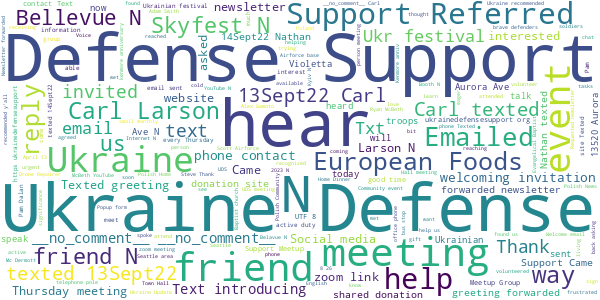

In [ ]:
# Create a WordCloud object
wordcloud_raw = WordCloud(background_color="white", max_words=2000, include_numbers=True, collocation_threshold=5, width=600, height=300, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud_raw.generate(long_string)
# Visualize the word cloud
wordcloud_raw.to_image()

# Create a WordCloud object
wordcloud_raw = WordCloud(background_color="white", max_words=2000, include_numbers=True, collocation_threshold=5, width=600, height=300, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud_raw.generate(long_string_tidy)
# Visualize the word cloud
wordcloud_raw.to_image()

## 2. Model

### 2.1 BOW Model

#### 2.1a Baseline BOW Model
- Tokenize dataset and build the vocablulary (with `CountVectorizer`)  
- Using the built-in `English` stopwords list  $todo: which tokens were dropped
- Vocabulary and features  
- Create bow representation of training data - SciPy sparse matrix
- dtm "dense" NumPy array to look actual content

In [ ]:
#tokenize train data and build the vocabulary
vect_base = CountVectorizer(stop_words='english').fit(text_train)

# `transform` converts text to a bow representation: SciPy sparse matrix only stores non-zero entries
X_base = vect_base.transform(text_train)
print("X_base:\n{}".format(repr(X_base)))

# dense dtm
#dtm_base = X_base.to_array()
#print ("document-term dimensions:", dtm_base.shape)

X_base:
<326x870 sparse matrix of type '<class 'numpy.int64'>'
	with 2193 stored elements in Compressed Sparse Row format>


In [ ]:
# vocab with attribute vocabulary_ <class 'dict'>
print("Vocab size: {}".format(len(vect_base.vocabulary_)))
#print("Vocab (with word indices): {}".format(vect_base.vocabulary_))

#get features
feature_names_base = vect_base.get_feature_names_out() #ordered alphabetically
#preview features
print("Number of features: {}".format(len(feature_names_base)))
print("First 20 features:\n{}".format(feature_names_base[:20]))
print("Features 2010 to 2030:\n{}".format(feature_names_base[2010:2030]))
print("Every 500th feature:\n{}".format(feature_names_base[::500]))

Vocab size: 870
Number of features: 870
First 20 features:
['10' '100' '11' '12345' '12532050468' '13' '13520' '13sept22' '14'
 '14sept22' '16' '20' '2022' '2023' '23' '25' '26' '300' '33' '365']
Features 2010 to 2030:
[]
Every 500th feature:
['10' 'nathan']


- Baseline WordCloud     

In [ ]:
# Join tokens together.
long_string = ','.join(vect_base.vocabulary_) #$was .join(list(text_train))
len(long_string)

6435

In [ ]:
vect_base.vocabulary_ #$private
{k: vect_base.vocabulary_[k] for k in list(vect_base.vocabulary_)[:K_PRIVATE]}
list(vect_base.vocabulary_)[:K_PRIVATE]

['carl', 'met', 'ivan', 'uds', 'meeting']

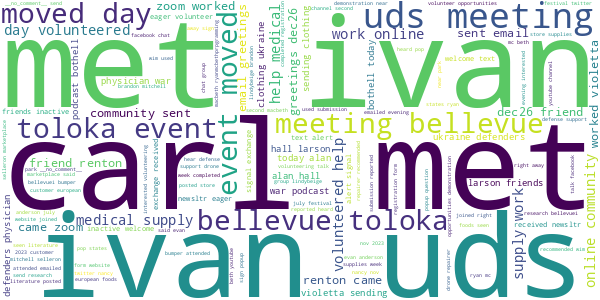

In [ ]:
# Create a WordCloud object
wordcloud_base = WordCloud(background_color="white", max_words=5000, include_numbers=True, collocation_threshold=5, width=600, height=300, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud_base.generate(long_string)
# Visualize the word cloud
wordcloud_base.to_image()

#### Confirm code

In [ ]:
long_string[:40] #$private

'carl,met,ivan,uds,meeting,bellevue,tolok'

In [ ]:
from collections import Counter

# count word frequency, sort and return just 20
counter = Counter(" ".join(list(text_train)).split())

most_common = counter.most_common(20)
most_common

[('to', 156),
 ('and', 118),
 ('N/A', 96),
 ('you', 86),
 ('the', 79),
 ('in', 78),
 ('Ukraine', 78),
 ('a', 75),
 ('about', 74),
 ('did', 66),
 ('Defense', 64),
 ('hear', 61),
 ('Support?:', 57),
 ('for', 44),
 ('with', 44),
 ('at', 41),
 ('How', 41),
 ('of', 40),
 ('an', 30),
 ('He', 30)]

#### 2.1b Candidate 1 BOW Model
Improve the Extraction of Words

- `min_df` Cut back on features that appear in less than min # of docs. Don't use tokens that appear in only n_min document(s).  
Loses most numbers: While most numbers don't have semantic meaning, some may, for example 401k.

- `max-df` to discard words that appear too frequently.

- `stopwords` discard a predefined list of meaningless words

- `n-grams` bi-grams and tri-grams can help with interpretability

Note: Weeding out the meaningful from the not meaningful "words" can be tricky.

Should be less obscure words or misspellings.  
Fewer features help with speed and made the topics more interpretable (with throwing away useless features).  

- `tf-idf` Rescaling the Data with tf-idf
\begin{equation*}
\text{tfidf}(w, d) = \text{tf} \log\big(\frac{N + 1}{N_w + 1}\big) + 1
\end{equation*}

Low tf-idf features means either used very commonly across documents or only used sparingly (and only in very long documents, which n/a here).

High tf-idf appear frequently in a document but not in very many documents -> descriptive of that document.

Low idf - appear frequently and therefore deemed less important.  But are they?  Seems everybody's bringing up same points.  Use your judgement when interpreting algorithms.

In [ ]:
#tokenize train data and build the vocabulary
vect_c1 = TfidfVectorizer(min_df = .01, ngram_range=(1, 3), stop_words="english")#, max_df=.99, norm=None)

# `transform` converts text to a bow representation: SciPy sparse matrix only stores non-zero entries
X_c1 = vect_c1.fit_transform(text_train)

In [ ]:
# vocab with attribute vocabulary_ <class 'dict'>
print("Vocab size: {}".format(len(vect_c1.vocabulary_)))
#print("Vocab (with word indices): {}".format(vect_c1.vocabulary_))

# get the feature names from the vectorizer
#feature_names_c1 = vect_c1.get_feature_names() #ordered alphabetically
feature_names_c1 = np.array(vect_c1.get_feature_names_out())
print("Number of features: {}".format(len(feature_names_c1)))
print("First 20 features:\n{}".format(feature_names_c1[:20]))

Vocab size: 192
Number of features: 192
First 20 features:
['13520' '13520 aurora' '13520 aurora ave' '13sept22' '13sept22 carl'
 '13sept22 carl texted' '14sept22' '14sept22 nathan'
 '14sept22 nathan texted' '2023' '__no_comment__' 'active' 'april' 'asked'
 'attended' 'aurora' 'aurora ave' 'ave' 'bellevue' 'came']


In [ ]:
#save vocab c1 
'''csv_columns = ['word','idx']
csv_file = "myExplore/vocab_base_index_tfidif_min01_max99.csv"
try:
    with open(csv_file, 'w') as f:
        for key in vect_c1.vocabulary_.keys():
            f.write("%s,%s\n"%(key,vect_c1.vocabulary_[key]))
except IOError:
    print("I/O error")'''


'csv_columns = [\'word\',\'idx\']\ncsv_file = "myExplore/vocab_base_index_tfidif_min01_max99.csv"\ntry:\n    with open(csv_file, \'w\') as f:\n        for key in vect_c1.vocabulary_.keys():\n            f.write("%s,%s\n"%(key,vect_c1.vocabulary_[key]))\nexcept IOError:\n    print("I/O error")'

In [ ]:
# find maximum value for each of the features over dataset:
max_value = X_c1.max(axis=0).toarray().ravel()
print("Max value shape:", max_value.shape)

sorted_by_tfidf = max_value.argsort()

print("Features with lowest tfidf:\n{}".format(feature_names_c1[sorted_by_tfidf[:20]]))

print("Features with highest tfidf: \n{}".format(feature_names_c1[sorted_by_tfidf[-20:]]))

sorted_by_idf = np.argsort(vect_c1.idf_)
print("Features with lowest idf:\n{}".format(feature_names_c1[sorted_by_idf[:20]]))

Max value shape: (192,)
Features with lowest tfidf:
['aurora ave' 'ave' '13520' '13520 aurora' 'ukrainedefensesupport org'
 'aurora' '13520 aurora ave' 'way did hear' 'support way did'
 'support way' 'defense support way' 'way did' 'event did'
 'event did hear' 'support event did' 'defense support meetup'
 'support meetup group' 'meetup group' 'support meetup'
 'defense support ukraine']
Features with highest tfidf: 
['facebook' 'festival' 'email' 'kent' 'instagram' 'friends' 'carl' 'rally'
 'church' 'txt' 'twitter' 'emailed' 'did' 'poster' 'ukraine' 'com' 'news'
 'near' '__no_comment__' 'asked']
Features with lowest idf:
['ukraine' 'did' 'support' 'defense' 'defense support'
 'ukraine defense support' 'ukraine defense' 'hear' 'did hear ukraine'
 'hear ukraine defense' 'hear ukraine' 'did hear' 'meeting' 'friend'
 'texted' 'event' 'carl' '__no_comment__' 'email' 'defense support event']


- Candidate 1 WordCloud

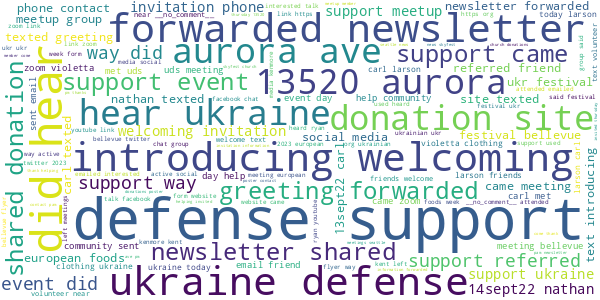

In [ ]:
# Join tokens together.
#long_string = ','.join(list(text_train))
long_string = ','.join(vect_c1.vocabulary_)
len(long_string)

# Create a WordCloud object
wordcloud = WordCloud(stopwords = "english", background_color="white", max_words=5000, include_numbers=True, collocation_threshold=5, width=600, height=300, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

### 2.2 Topic Modeling and Document Clustering
#### 2.2a Baseline Topic Modeling and Document Clustering
Assigning documents to one or multiple topis, usually without supervision.  

If each document can have more than one topic, the task relate to the decomposition methods (PCA, NMF and t-SNE). Each of the components we learn then corresponds to one topic, and the coefficients in the representation of a document tell us how strongly related that document is to a particular topic.

Decomposition algo: Latent Dirichlet Allocation
the LDA model tries to find groups of words (the topics) that appear together frequently.  It requires that each doc can be understood as a "mixture" of a subset of the topics.  A topic may not result in a semantic meaning - groups of words appearing together not as expected by a human.

In [ ]:
N_BASE = 10
lda_base = LatentDirichletAllocation(n_components=N_BASE, learning_method="batch", max_iter=25, random_state=0)
# Build the model and transform the data in one step
# Computing transform takes some time, and we can save time by doing both at once
document_topics_base = lda_base.fit(X_base)

print("lda_base.components_.shape: {}".format(lda_base.components_.shape))

lda_base.components_.shape: (10, 870)


In [ ]:
# for each topic (a row in the components_), sort the features (ascending).
# Invert rows with [:, ::-1] to make sorting descending
sorting_base = np.argsort(lda_base.components_, axis=1)[:, ::-1]
# get the feature names from the vectorizer:
#np.array(feature_names_base)

In [ ]:
# Print out the 10 topics:
nlp_utils.print_topics(topics=range(10), feature_names=np.array(feature_names_base), sorting=sorting_base, topics_per_chunk=5, n_words=10)

topic 0                  topic 1                  topic 2                  topic 3                  topic 4                  
--------                 --------                 --------                 --------                 --------                 
festival                 texted                   meeting                  __no_comment__           https                    
bellevue                 txt                      help                     meeting                  information              
ukr                      forwarded                ukraine                  event                    help                     
poster                   newsletter               event                    member                   zoom                     
2023                     meeting                  text                     came                     newsletter               
kenmore                  shared                   foods                    website                  musician          


Preview data:

In [ ]:
# vocab with attribute vocabulary_ <class 'dict'>
print("Vocab size: {}".format(len(vect_base.vocabulary_)))
#print("Vocab (with word indices): {}".format(vect_base.vocabulary_))

#preview features
feature_names_base = vect_base.get_feature_names_out() #ordered alphabetically
print("Number of features: {}".format(len(feature_names_base)))
print("First 20 features:\n{}".format(feature_names_base[:20]))
print("Features 510 to 530:\n{}".format(feature_names_base[510:530]))
print("Every 100th feature:\n{}".format(feature_names_base[::100]))

Vocab size: 870
Number of features: 870
First 20 features:
['10' '100' '11' '12345' '12532050468' '13' '13520' '13sept22' '14'
 '14sept22' '16' '20' '2022' '2023' '23' '25' '26' '300' '33' '365']
Features 510 to 530:
['newsletter' 'newsltr' 'night' 'notice' 'noticed' 'notified' 'notifying'
 'nov' 'nsp' 'number' 'nurse' 'nyc' 'ocp' 'oe' 'offered' 'office'
 'officer' 'official' 'oleg' 'olympic']
Every 100th feature:
['10' 'baptist' 'dainius' 'friend' 'july' 'nathan' 'prosser' 'skills'
 'ukrainedefensesupport']


In [ ]:
#save vocab base 
'''csv_columns = ['word','idx']
csv_file = "myExplore/vocab_base_index.csv"
try:
    with open(csv_file, 'w') as f:
        for key in vect_base.vocabulary_.keys():
            f.write("%s,%s\n"%(key,vect_base.vocabulary_[key]))
except IOError:
    print("I/O error")
'''

'csv_columns = [\'word\',\'idx\']\ncsv_file = "myExplore/vocab_base_index.csv"\ntry:\n    with open(csv_file, \'w\') as f:\n        for key in vect_base.vocabulary_.keys():\n            f.write("%s,%s\n"%(key,vect_base.vocabulary_[key]))\nexcept IOError:\n    print("I/O error")\n'

#### 2.2b Candidate 1 Topic Modeling and Document Clustering
Model 10 topics

In [ ]:
n_topics_c1 = 10

lda_c1 = LatentDirichletAllocation(n_components=n_topics_c1, learning_method="batch", max_iter=25, random_state=0)
# Build the model and transform the data in one step
# Computing transform takes some time and we can save time by doing both at once
document_topics_c1 = lda_c1.fit_transform(X_c1)

print("lda_c1.components_.shape: {}".format(lda_c1.components_.shape))

lda_c1.components_.shape: (10, 192)


In [ ]:
n_topics_c1 = 10

lda_c1 = LatentDirichletAllocation(n_components=n_topics_c1, learning_method="batch", max_iter=25, random_state=0)
# Build the model and transform the data in one step
# Computing transform takes some time and we can save time by doing both at once
document_topics_c1 = lda_c1.fit_transform(X_c1)

print("lda_c1.components_.shape: {}".format(lda_c1.components_.shape))

lda_c1.components_.shape: (10, 192)


In [ ]:
# for each topic (a row in the components_), sort the features (ascending).
# Invert rows with [:, ::-1] to make sorting descending
sorting_c1 = np.argsort(lda_c1.components_, axis=1)[:, ::-1]


In [ ]:
# Print out the n topics:
nlp_utils.print_topics(topics=range(n_topics_c1), feature_names=feature_names_c1,
                           sorting=sorting_c1, topics_per_chunk=4, n_words=10)

topic 0                  topic 1                  topic 2                  topic 3                  
--------                 --------                 --------                 --------                 
friend                   festival                 support                  skyfest                  
facebook                 bellevue                 did                      poster                   
help                     sent                     ukraine defense support  event                    
church                   emailed                  ukraine defense          ukrainian                
https                    festival bellevue        defense support          community                
ukraine                  email                    defense                  seattle                  
come                     newsletter               hear ukraine defense     com                      
org                      text                     hear ukraine             welcome         

Topics may be specific or not specific enough, many are hard to interpret.  

Examine one topic.  
Confirm the intuition gained from looking at the highest-ranking words per topic by looking at the documents that are assigned to this topic. 

What kinds of comments are assigned to this topic? 

In [ ]:
# sort by weight of "balance" topic 0
topic_c1  = np.argsort(document_topics_c1[:, 0])[::-1]
print(topic_c1.shape)

# print the five documents where the topic is most important
for i in topic_c1[:10]:
    print("-- note: beginning only --")
    ##print(text_train.iloc[i]) $private
    print(text_train.iloc[i][:10])

    

(326,)
-- note: beginning only --
I texted h
-- note: beginning only --
I reached 
-- note: beginning only --
I emailed 
-- note: beginning only --
via guest 
-- note: beginning only --
Friend in 
-- note: beginning only --
Emailed th
-- note: beginning only --
So great t
-- note: beginning only --
Facebook 

-- note: beginning only --
Facebook
-- note: beginning only --
Friend 
N/


Another way to inspect topics is to see how much weight each topic gets overall (by summing the document_topics over all reviews).  We name each topic by the two most common tokens.

In [ ]:
topic_names_c1 = ["{:>2} ".format(i) + " ".join(words)
               for i, words in enumerate(feature_names_c1[sorting_c1[:, :2]])]

topic_names_c1

[' 0 friend facebook',
 ' 1 festival bellevue',
 ' 2 support did',
 ' 3 skyfest poster',
 ' 4 social texted',
 ' 5 txt carl',
 ' 6 ukraine day',
 ' 7 email flyer',
 ' 8 meeting met',
 ' 9 __no_comment__ news']

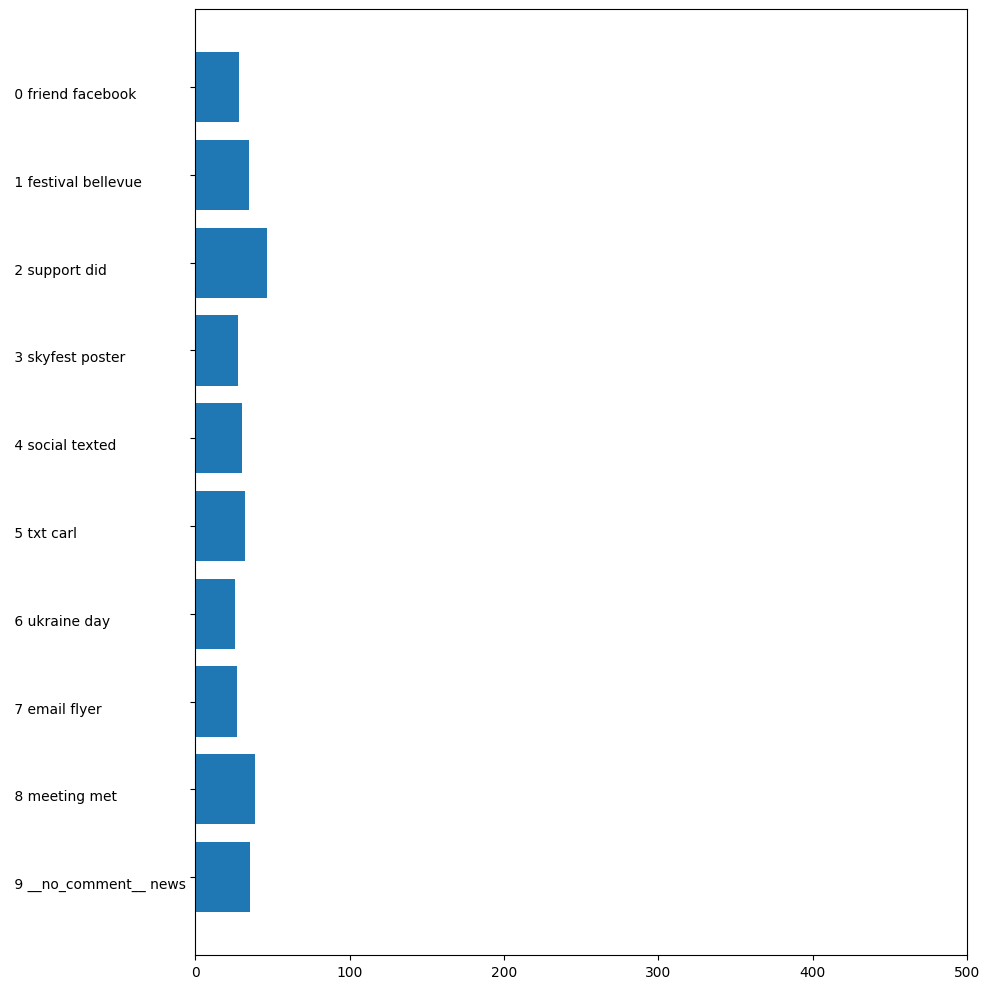

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

col = 0
start = col * n_topics_c1
end = (col + 1) * n_topics_c1
ax.barh(np.arange(n_topics_c1), np.sum(document_topics_c1, axis=0)[start:end])
ax.set_yticks(np.arange(n_topics_c1))
ax.set_yticklabels(topic_names_c1[start:end], ha="left", va="top")
ax.invert_yaxis()
ax.set_xlim(0, 500)
yax = ax.get_yaxis()
yax.set_tick_params(pad=130)
plt.tight_layout()

#### Note: Limitations of BOW and subsequent modeling with LDA
- Semantic meaning, i.e different tokens mean the same thing but not captured by BOW  
- Haven't done lemmatization: i.e. be and was is the same verb  
- Bi-grams and tri-grams are more comprehensible to humans but skipping uni-grams is not usually recommended
- Recommend to manually fine-tune stopwords? Would need input
- Recommend to remove PII

#### 2.2c Candidate 1 Visualize LDA
using pyLDAvis package - Python library for interactive topic model visualization

In [ ]:
##from pyLDAvis import sklearn as sklearn_lda
import pyLDAvis.lda_model
import pyLDAvis # for interactive topic model visualization

In [ ]:
LDAvis_data_filepath = os.path.join('myVis/ldavis_prepared_'+str(n_topics_c1))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    #LDAvis_prepared = sklearn_lda.prepare(lda_c1, X_c1, vect_c1)
    LDAvis_prepared = pyLDAvis.lda_model.prepare(lda_c1, X_c1, vect_c1)

    with open(LDAvis_data_filepath, 'wb') as f:
            dump(LDAvis_prepared, f)

    # load the pre-prepared pyLDAvis data from disk
    with open(LDAvis_data_filepath, 'rb') as f:
        LDAvis_prepared = load(f)
    pyLDAvis.save_html(LDAvis_prepared, 'myVis/ldavis_prepared_'+ str(n_topics_c1) +'.html')
    

###  2.3 K-Means Clustering

#### 2.3b Candidate 1 K-Means Clustering

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

ds = X_c1.toarray()
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init='auto').fit(ds)

kmeans_labels = kmeans.labels_

kmeans_labels

array([0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 2, 0, 3, 0, 0, 0, 3, 3, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 3, 0, 0, 1, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0,

In [ ]:
unique, counts = np.unique(kmeans_labels, return_counts=True)
unique, counts

(array([0, 1, 2, 3], dtype=int32), array([290,   7,  11,  18]))

In [ ]:
np.where(kmeans_labels == 2)

(array([ 11,  29,  51,  74,  98, 112, 132, 145, 148, 165, 201]),)

In [ ]:
df_tidy.loc[np.where(kmeans_labels == 3)] #$private
IPython.display.clear_output(True)


- Vis 2D

In [ ]:
PCA_model = PCA(n_components=2)
y_hat = PCA_model.fit_transform(ds)
print(y_hat.shape)


(326, 2)


In [ ]:
x = y_hat[:,0]
y = y_hat[:,1]
labels = df_tidy['Contact rpt. description'].str[:30]

Text(0.5, 1.0, '2D: How did you hear...')

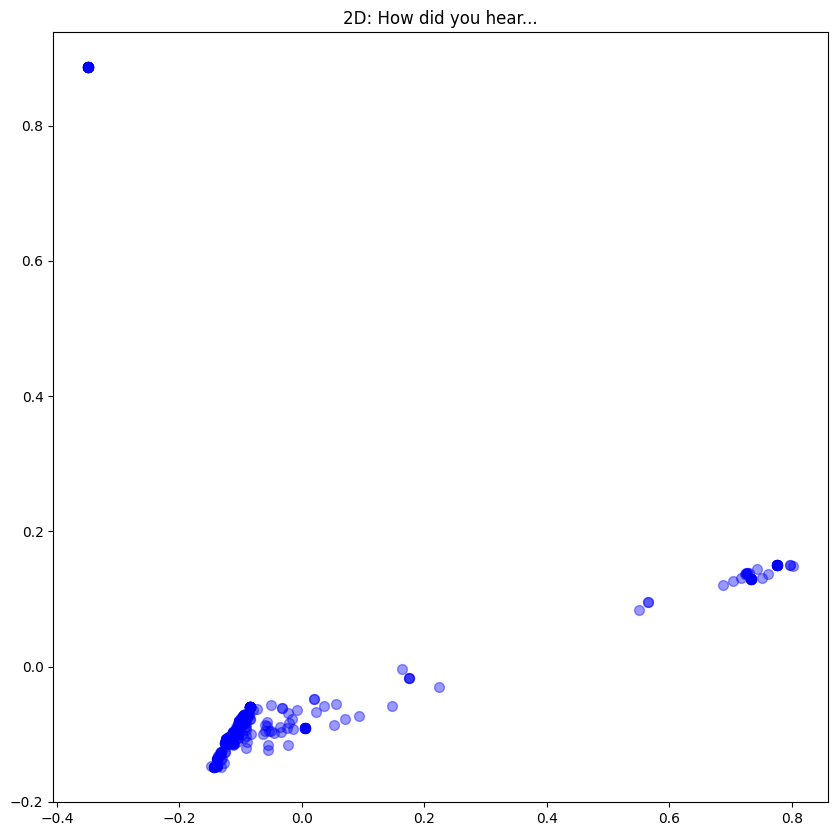

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(x,y, color = 'blue', alpha=0.4, s=50)
plt.title('2D: How did you hear...')

In [ ]:
kmeans_labels #class numpy.ndarray
df_tidy['cluster'] = kmeans_labels

#set cluster colors
dict_c = {0:'b', 1:'g', 2:'r', 3: 'orange'}
df_tidy['color'] = df_tidy['cluster'].map(dict_c)

#preview 
df_tidy.head() #$private
IPython.display.clear_output(True)

Text(0.5, 1.0, '2D: How did you hear...')

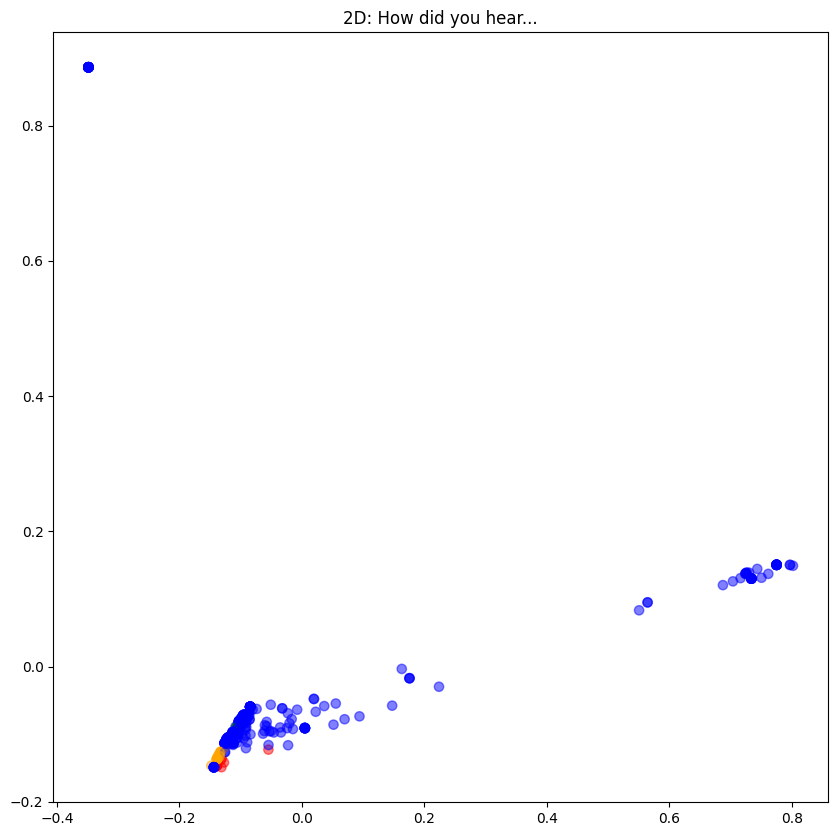

In [ ]:
plt.figure(figsize=(10,10))

plt.scatter(x,y, color = df_tidy['color'], alpha=0.5, s=45)
plt.title('2D: How did you hear...')

) missing from current font.yGitrepo/my-razom/.venv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 13 (
  func(*args, **kwargs)
) missing from current font.yGitrepo/my-razom/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


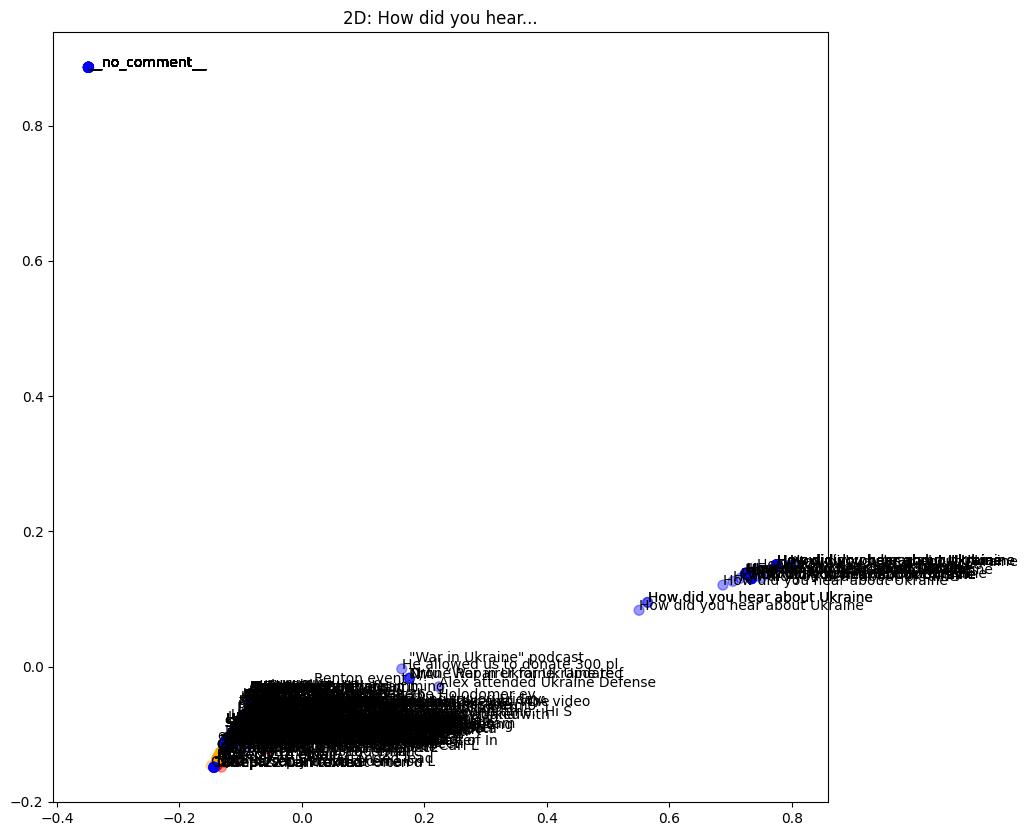

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(x,y, color = df_tidy['color'], alpha=0.4, s=50)
plt.title('2D: How did you hear...');

for i, txt in enumerate(labels):
    ax.annotate(txt, (x[i], y[i]))

- Vis 3D

In [ ]:
PCA_model = PCA(n_components=3)
y_hat = PCA_model.fit_transform(ds)
print(y_hat.shape)

(326, 3)


In [ ]:
x = y_hat[:,0]
y = y_hat[:,1]
z = y_hat[:,2]

In [ ]:
df_tidy3d = df_tidy.copy()
df_tidy3d['x'] = x
df_tidy3d['y'] = y
df_tidy3d['z'] = z
df_tidy3d['label'] = df_tidy3d['all_text'].str[:30]

df_tidy3d.head() #$private
IPython.display.clear_output(True)


In [ ]:
#$was fig = px.scatter_3d(y_hat, x=x,y=y,z=z, opacity = .5, color=df_tidy['color'], title= "3D: How did u hear ...", text = labels, width=600, height=600)
fig = px.scatter_3d(df_tidy3d, x='x',y='y',z='z', opacity = .5, color='color', title= "3D: How did u hear ...", hover_data = 'label', width=800, height=800)
fig.show()


In [ ]:
fig.write_html("myVis/3D_vis.html")

#### for Git
![3D static vis](myVis/3D_4Clusters_static.PNG)

In [ ]:
mystop

NameError: name 'mystop' is not defined

# Xtra

#### Bag-of-Words
- Tokenize dataset and build the vocablulary  
- Revew vocabulary and features  
- Create bow representation of training data - SciPy sparse matrix
- dtm "dense" NumPy array to look at the actual content

In [ ]:
#by default extracts tokens using a regex "\b\w\w+\b" - all sequences of chars that consist of at least two letters or numbers (\w) and that are separated by word boundaries(\b) => no single letter words, splits `don't` or `bit.ly`
vectorizer = CountVectorizer(min_df=0)

# `fit` to tokenize train data and build the vocabulary - <class 'dict'> {word,index}
vectorizer.fit(text_train.iloc[:10])

# access vocab with attribute vocabulary_ <class 'dict'>
print("Vocab size: {}".format(len(vectorizer.vocabulary_)))
print("Vocab (with word indices): {}".format(vectorizer.vocabulary_))


KeyboardInterrupt



In [ ]:
# get features
print("Vocab size:{}".format(len(vectorizer.get_feature_names())))
print("Vocab (ordered alphabetically): {}".format((vectorizer.get_feature_names())))

In [ ]:
# `transform` to convert text to a bag of words
bow = vectorizer.transform(text_train.iloc[:10]) 
#SciPy sparse matrix only stores non-zero entries

print("Bag-of-words: {}".format(repr(bow)))

In [ ]:
# CountVectorizer uses a sparse array to save memory
# convert to a "dense" NumPy array to look actual content
dtm = bow.toarray()

print ("document-term dimensions:", dtm.shape)
print (dtm)


Manually get word frequencies

In [ ]:
#10 records x 121 words
print (dtm.shape)

#each row=record, how many words each?
print(np.sum(dtm, axis=1))

#each column=word, frequency of each word?
print(np.sum(dtm, axis=0))

#confirm sums
np.sum(dtm, axis=1).sum(), np.sum(dtm, axis=0).sum()

In [ ]:
#$xtra save vocab base 
csv_columns = ['word','idx']
csv_file = "myExplore/vocab_ngrams3_index.csv"
try:
    with open(csv_file, 'w') as f:
        for key in vect_ngram.vocabulary_.keys():
            f.write("%s,%s\n"%(key,vect_ngram.vocabulary_[key]))
except IOError:
    print("I/O error")

In [ ]:
# my_stop_words_custom = ['ukraine defense', 'defense support', 'did']
# my_stop_words = list(text.ENGLISH_STOP_WORDS.union(my_stop_words_custom))

In [ ]:
#$xtra WordCloud option w/ bilinear interpolation
#stop_words = ["https", "co", "RT"] + list(STOPWORDS)
#$todo https://stackoverflow.com/questions/53997443/how-to-add-extra-stop-words-in-addition-to-default-stopwords-in-wordcloud
wordcloud = WordCloud(background_color="white", width=800, height=400,).generate(long_string) #stopwords = stop_words, 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
#$xtra LDA for candidate #2
LDAvis_data_filepath = os.path.join('myVis/ldavis_prepared_'+str(n_topics_c2))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.lda_model.prepare(lda_c2, X_c2, vect_c2)
    with open(LDAvis_data_filepath, 'wb') as f:
            dump(LDAvis_prepared, f)

    # load the pre-prepared pyLDAvis data from disk
    with open(LDAvis_data_filepath, 'rb') as f:
        LDAvis_prepared = load(f)
    pyLDAvis.save_html(LDAvis_prepared, 'myVis/ldavis_prepared_'+ str(n_topics_c2) +'.html')